# Tech Challenge da Fase 4. 


Seu desafio é criar um modelo preditivo de redes neurais Long Short
Term Memory (LSTM) para predizer o valor de fechamento da bolsa de valores
de uma empresa à sua escolha e realizar toda a pipeline de desenvolvimento,
desde a criação do modelo preditivo até o deploy do modelo em uma API que
permita a previsão de preços de ações.

## arquitetura da solução (preliminar)

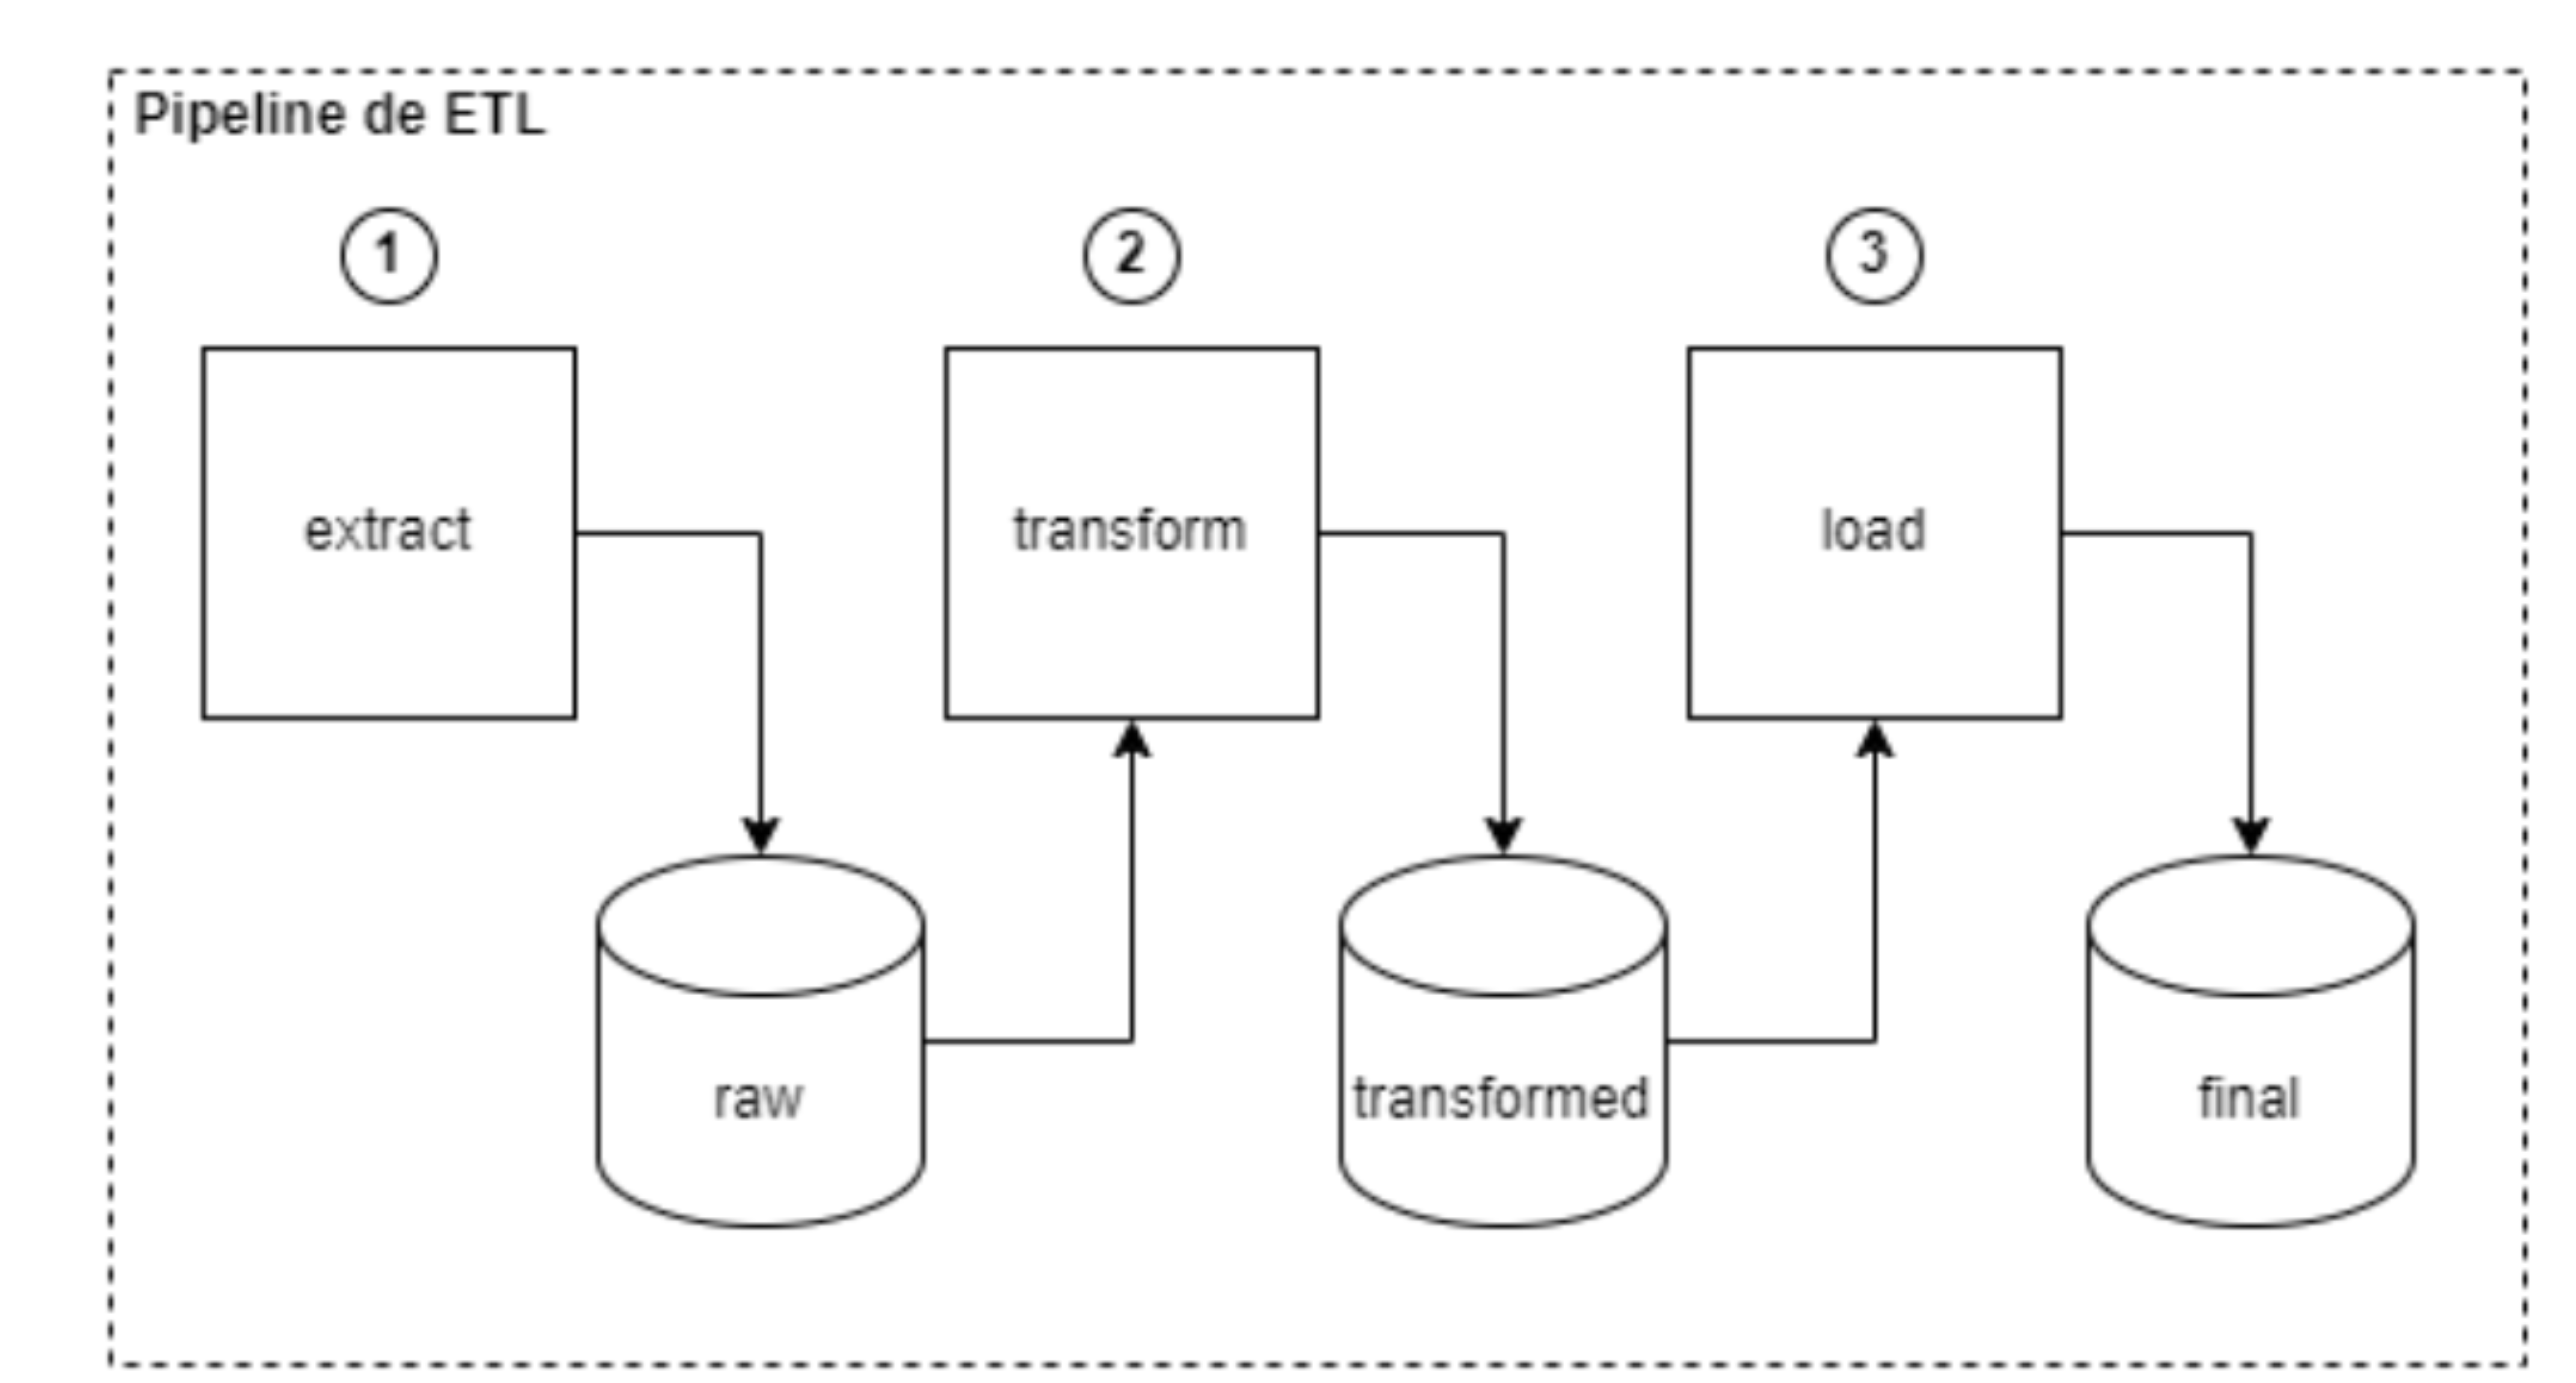

### 1 - Extract
Os dados brutos do preço do ativo BBAS3 são obtidos através da biblioteca Yfinance, e carregados em um DataFrame do PySpark. O dados obtidos são persisitdos em formato Parquet na camada 'raw'. Durante essa etapa, os dados são transferidos da origem oara o ambiente de processamento, sem modificações, assegurando que todos os registros relevantes estejam disponíveis para o processamento subsequente.


### 2 - Transform

Registros com valores ausentes em "Close" são removidos para garantir a integridade dos cálculos. Em seguinda, os dados são agrupados por ano e mês para calcular a média mensal do preço do ativo BBAS3. A seguir, os dados do mês corrente são excluídos para evitar distorções em análises ou previsões, já que o mês corrente pode ter dados incompletos. Além disso, lags (defasagens) de até 6 meses são criadas para capturar a dependência temporal, e estatísticas móveis como média, desvio padrão, valor mínimo e máximo dos últimos 6 meses são calculadas. Componentes sazonais, como trimestre, também são extraídos para melhor representar as variações temporais no modelo.

### 3 - Load

Os dados transformados e enriquecidos são preparados para uso em análises ou modelagem de machine learning. O DataFrame final, contendo todas as features necessárias, é salvo em formato Parquet na camada ´final'. Esta etapa garante que os dados estejam prontos para ser consumidos por outras aplicações ou processos, proporcionando um formato eficiente e otimizado para processamento adicional.


# 1 - Extract

## 1.1 - Coleta e Pré-processamento dos Dados

Coleta de Dados: utilize um dataset de preços históricos de ações,
como o Yahoo Finance ou qualquer outro dataset financeiro disponível


## 1.2 - Obtenção dos dados do BBAS3

No notebook criado etl.ipynb instale a biblioteca do yfinance para obtenção da série temporal em uma célula do notebook:

In [1]:
%pip install yfinance


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf

# Especifique o símbolo da empresa que você vai trabalhar
# Configure data de início e fim da sua base
symbol = 'BBAS3.SA'
start_date = '2019-06-01'
end_date = '2025-07-01'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

/var/folders/nj/m_h5cgyd6z3b2jy59pdv92p00000gn/T/ipykernel_6394/564515858.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [3]:
if df is not None:
	print(df.head(5))
else:
	print("DataFrame 'df' is None. Please check your data download step.")

Price           Close       High        Low       Open    Volume
Ticker       BBAS3.SA   BBAS3.SA   BBAS3.SA   BBAS3.SA  BBAS3.SA
Date                                                            
2019-06-03  17.893122  18.051133  17.741980  17.937778  15384800
2019-06-04  18.185101  18.185101  17.869078  17.965258  22809800
2019-06-05  17.683590  18.185106  17.583973  18.157626  18513000
2019-06-06  18.133577  18.157623  17.673282  17.886254  15959800
2019-06-07  17.985870  18.246933  17.985870  18.174797  13818200


## 1.3 - visualizar a série temporal obtida:

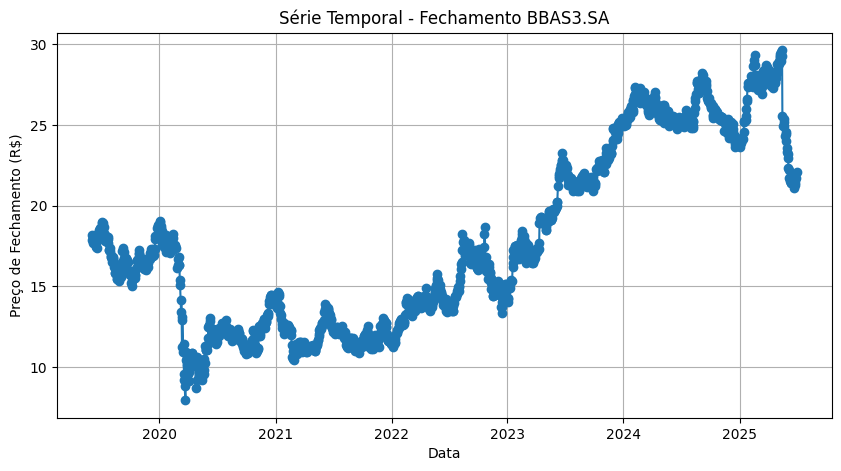

In [4]:
import matplotlib.pyplot as plt

if 'df' in globals():
	# Plota todos os pontos da série de fechamento
	plt.figure(figsize=(10, 5))
	plt.plot(df.index, df[("Close", "BBAS3.SA")], marker='o', linestyle='-')
	plt.title("Série Temporal - Fechamento BBAS3.SA")
	plt.xlabel("Data")
	plt.ylabel("Preço de Fechamento (R$)")
	plt.grid(True)
	plt.show()
else:
	print("DataFrame 'df' is not defined. Please run the cell where 'df' is assigned.")

## 1.4 - Implementação do ETL com PySpark


### Engenharia de Features para Série Temporal
A engenharia de features é um passo crucial na preparação dos dados de séries temporais para modelos de ML. A seguir, é listada algumas das features mais comuns extraídas de séries temporais:

+ *Lags (Defasagens):* Valores anteriores da série temporal são usados como características.
+ *Médias Móveis:* Média dos valores anteriores para suavizar a série e capturar tendências.
+ *Diferenças:* Diferença entre valores consecutivos para remover tendências e tornar a série estacionária.
+ *Componentes Sazonais:* Extração de padrões sazonais que se repetem em intervalos regulares.
+ *Transformações Estatísticas:* Desvios padrão, variação e outras medidas estatísticas ao longo do tempo.
+ *Features Calendáricas:* Dia da semana, mês, feriados e outras variáveis temporais.

A engenharia de features melhora a capacidade do modelo de capturar padrões temporais complexos e aumenta a precisão das previsões.

### Implementação do ETL com PySpark

A seguir serão obtidas as features para a tabela demandada no levantamento de requisitos junto dos stakeholders do projeto usando o PySpark.

PySpark é uma interface para Apache Spark em Python. Spark é uma poderosa ferramenta de computação distribuída usada para processar grandes volumes de dados de maneira eficiente, especialmente em clusters de computadores.

PySpark inclui várias bibliotecas que facilitam essas operações, no presente projeto utilizaremos o DataFrame do PySpark, que similar aos DataFrames do Pandas, é uma abstração para dados estruturados, mas distribuída e otimizada para grandes volumes de dados.

Link da documentação do PySpark: https://spark.apache.org/docs/3.1.1/api/python/index.html



### 1. Etapa de "Extract"

Nesta etapa, vamos extrair os dados brutos de uma fonte, neste caso, assumimos que já temos um DataFrame df carregado. Vamos criar uma pasta chamada data/raw e salvar os dados no formato .parquet.

In [5]:
import os
import pandas as pd
from pyspark.sql import SparkSession, types as T

# -------------------------------------------------
# 1. Ambiente Spark
# -------------------------------------------------
os.environ.setdefault("JAVA_HOME", "/opt/homebrew/opt/openjdk@17")
spark = (SparkSession.builder
         .appName("ETL tech_challenge")
         .getOrCreate())

# -------------------------------------------------
# 2. Pandas → preparação
# -------------------------------------------------
# df é o DataFrame obtido do yfinance (colunas MultiIndex)
# Exemplo visual: (‘Close’, ’BBAS3.SA’), (‘High’, ’BBAS3.SA’), ...

# a) “Achatar” o MultiIndex para um único nível
df_flat = df.copy()
df_flat.columns = [col[0] for col in df_flat.columns]     # → ['Close','High','Low','Open','Volume']

# b) Trazer o índice Date para coluna
df_flat = df_flat.reset_index()                           # primeira coluna passa a ser 'Date'

# c) Inferir automaticamente quais colunas são numéricas
num_cols = [c for c in df_flat.columns if c != 'Date']

# d) Tipos corretos
df_flat[num_cols] = df_flat[num_cols].apply(pd.to_numeric, errors='coerce')
df_flat['Date']     = pd.to_datetime(df_flat['Date'])

# -------------------------------------------------
# 3. Pandas → Spark (schema explícito ajuda na leitura em downstream)
# -------------------------------------------------
schema = T.StructType(
    [T.StructField('Date',   T.DateType(),   False)] +
    [T.StructField(c,        T.DoubleType() if c != 'Volume' else T.LongType(), True)
     for c in num_cols]
)

df_spark = spark.createDataFrame(df_flat, schema=schema)

# -------------------------------------------------
# 4. Persistir em Parquet
# -------------------------------------------------
raw_data_path = "../data/raw"
(df_spark
  .repartition(1)           # opcional: 1 arquivo .parquet
  .write.mode("overwrite")
  .parquet(raw_data_path))

df_spark.show(5)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/04 20:30:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+------------------+------------------+------------------+------------------+--------+
|      Date|             Close|              High|               Low|              Open|  Volume|
+----------+------------------+------------------+------------------+------------------+--------+
|2019-06-03| 17.89312171936035|18.051133229921934|17.741980445392354| 17.93777760203685|15384800|
|2019-06-04|18.185100555419922|18.185100555419922| 17.86907751713008|17.965258213937645|22809800|
|2019-06-05|17.683589935302734|18.185105579150974|17.583973437310334|18.157625934056153|18513000|
|2019-06-06|18.133577346801758|18.157622523129348|17.673281912244725| 17.88625403558788|15959800|
|2019-06-07|17.985870361328125| 18.24693283509786|17.985870361328125|18.174797306730888|13818200|
+----------+------------------+------------------+------------------+------------------+--------+
only showing top 5 rows


### 2. Etapa de "Transform"

Na etapa de transformação, vamos aplicar a engenharia de features ao DataFrame. Após as transformações, vamos salvar o resultado em uma nova pasta, por exemplo, data/transformed.

📌 Contexto
Seu DataFrame:

Índice: Date (datas)

Colunas: 
- Price Ticker Date
- Close
- High
- Low
- Open
- Volume (todas com Ticker BBAS3.SA)

Você deseja gerar:
- Lags de preços de fechamento (1 a 6 dias)
- Média móvel de 6 dias do Close
- Desvio padrão móvel de 6 dias do Close
- Máximo e mínimo móvel de 6 dias do Close
- Componentes sazonais (ano, mês, trimestre)
- Persistência em Parquet para modelagem ou análise posterior

In [6]:
from pyspark.sql.functions import (
    avg, col, concat, current_date, date_format, lag, lpad,
    month, quarter, stddev, to_date, year,
    min as spark_min, max as spark_max           # evita conflito com built-ins
)
from pyspark.sql.window import Window

# ──────────────────────────────────────────────
# 1. Leitura do parquet “bruto”
# ──────────────────────────────────────────────
raw_data_path = "../data/raw"
df = spark.read.parquet(raw_data_path)           # Date, Close, High, Low, Open, Volume

# garante que 'Date' está realmente como date (caso tenha vindo string)
df = df.withColumn("Date", to_date(col("Date")))

# ──────────────────────────────────────────────
# 2. Ano / mês corrente e filtro
# ──────────────────────────────────────────────
current_year  = date_format(current_date(), "yyyy").cast("int")
current_month = date_format(current_date(), "MM").cast("int")

df = (df
      .withColumn("ano", year(col("Date")))
      .withColumn("mes", month(col("Date")))
      .filter(~((col("ano") == current_year) & (col("mes") == current_month)))
)

# ──────────────────────────────────────────────
# 3. Limpeza de nulos (usaremos 'Close')
# ──────────────────────────────────────────────
df = df.na.drop(subset=["Close"])

# ──────────────────────────────────────────────
# 4. Agregação mensal – preço médio de fechamento
# ──────────────────────────────────────────────
df = (df
      .groupBy("ano", "mes")
      .agg(avg("Close").alias("preco_medio_close"))
)

# ──────────────────────────────────────────────
# 5. Coluna “anomes” para ordenação temporal
# ──────────────────────────────────────────────
df = df.withColumn(
        "anomes",
        to_date(concat(col("ano").cast("string"),
                       lpad(col("mes").cast("string"), 2, "0")), "yyyyMM")
     )

# ──────────────────────────────────────────────
# 6. Janela ordenada por data
# ──────────────────────────────────────────────
w = Window.orderBy("anomes")

# lags de 1 a 6 meses
for i in range(1, 7):
    df = df.withColumn(f"lag_{i}_mes_preco_medio_close", lag("preco_medio_close", i).over(w))

# métricas móveis (6 meses imediatamente anteriores)
range_6m = w.rowsBetween(-6, -1)
df = (df
      .withColumn("media_movel_6_meses_preco_medio_close",
                  avg("preco_medio_close").over(range_6m))
      .withColumn("desvio_padrao_movel_6_meses_preco_medio_close",
                  stddev("preco_medio_close").over(range_6m))
      .withColumn("valor_minimo_6_meses_preco_medio_close",
                  spark_min("preco_medio_close").over(range_6m))
      .withColumn("valor_maximo_6_meses_preco_medio_close",
                  spark_max("preco_medio_close").over(range_6m))
)

# componente sazonal (trimestre)
df = df.withColumn("trimestre", quarter("anomes"))

# ──────────────────────────────────────────────
# 7. Limpeza final e gravação
# ──────────────────────────────────────────────
df = (df
      .drop("anomes")  # já não é mais necessário
      .dropna()        # remove linhas incompletas (lags/médias do início da série)
)

transformed_data_path = "../data/transformed"
df.write.mode("overwrite").parquet(transformed_data_path)


25/07/04 20:30:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/04 20:30:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/04 20:30:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/04 20:30:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/04 20:30:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/04 20:30:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/04 2

##  O que este código faz:

- Carrega os dados do BBAS3.SA do Parquet.
- Calcula lags de 1 a 6 dias para Close.
- Calcula média móvel, desvio padrão, máximo e mínimo móvel (janela de 6 dias).
- Adiciona ano, mês e trimestre para análise sazonal.
- Remove NaNs gerados pelas janelas iniciais.
- Salva em Parquet para uso posterior em modelagem, análise ou dashboards.

## 3. Etapa de "Load"
Finalmente, na etapa de "Load", vamos carregar os dados transformados e forçar os tipos de dados necessários antes de salvar a versão final no formato .parquet.

In [7]:
from pyspark.sql.types import DecimalType, IntegerType

# carregando os dados transformados
transformed_data_path = "../data/transformed"
df = spark.read.parquet(transformed_data_path)

# forçando os tipos de dados
df = df.select(
    col("ano").cast(IntegerType()),
    col("mes").cast(IntegerType()),
    col("preco_medio_close").cast(DecimalType(5,2)),
    col("lag_1_mes_preco_medio_close").cast(DecimalType(5,2)),
    col("lag_2_mes_preco_medio_close").cast(DecimalType(5,2)),
    col("lag_3_mes_preco_medio_close").cast(DecimalType(5,2)),
    col("lag_4_mes_preco_medio_close").cast(DecimalType(5,2)),
    col("lag_5_mes_preco_medio_close").cast(DecimalType(5,2)),
    col("lag_6_mes_preco_medio_close").cast(DecimalType(5,2)),
    col("media_movel_6_meses_preco_medio_close").cast(DecimalType(5,2)),
    col("desvio_padrao_movel_6_meses_preco_medio_close").cast(DecimalType(5,2)),
    col("valor_minimo_6_meses_preco_medio_close").cast(DecimalType(5,2)),
    col("valor_maximo_6_meses_preco_medio_close").cast(DecimalType(5,2)),
    col("trimestre").cast(IntegerType())
)

# persistindo os dados prontos para consumo
final_data_path = "../data/final"
df.write.mode("overwrite").parquet(final_data_path)

In [8]:
df.show(5)

+----+---+-----------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+-------------------------------------+---------------------------------------------+--------------------------------------+--------------------------------------+---------+
| ano|mes|preco_medio_close|lag_1_mes_preco_medio_close|lag_2_mes_preco_medio_close|lag_3_mes_preco_medio_close|lag_4_mes_preco_medio_close|lag_5_mes_preco_medio_close|lag_6_mes_preco_medio_close|media_movel_6_meses_preco_medio_close|desvio_padrao_movel_6_meses_preco_medio_close|valor_minimo_6_meses_preco_medio_close|valor_maximo_6_meses_preco_medio_close|trimestre|
+----+---+-----------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+-------------------------------------+----------------------------